# Autoencoder

<img src='Autoencoder_schema.png' style='width:280px;heigth:auto' />

https://www.tensorflow.org/tutorials/generative/autoencoder

# Install gwpy module to get the GW data

In [1]:
!pip install gwpy

     |████████████████████████████████| 1.4 MB 3.1 MB/s eta 0:00:01
     |████████████████████████████████| 51 kB 11.9 MB/s eta 0:00:01
     |████████████████████████████████| 77 kB 16.6 MB/s eta 0:00:01
     |████████████████████████████████| 45 kB 6.5 MB/s  eta 0:00:01
     |████████████████████████████████| 34.5 MB 120.6 MB/s eta 0:00:01
     |████████████████████████████████| 11.4 MB 82.8 MB/s eta 0:00:01
     |████████████████████████████████| 749 kB 59.3 MB/s eta 0:00:01
     |████████████████████████████████| 701 kB 92.0 MB/s eta 0:00:01
     |████████████████████████████████| 3.7 MB 108.3 MB/s eta 0:00:01
  Created wheel for ligo-segments: filename=ligo_segments-1.4.0-cp38-cp38-linux_x86_64.whl size=110316 sha256=2ab86a475a0be23ae5dba2cb1ff8a22d1e23d6aa422035366ed2a8d96933a571
  Stored in directory: /root/.cache/pip/wheels/3c/22/bd/6e3de97386f4d20261f7f76a6bd322e685999ef720f8054e31
Successfully built ligo-segments
You should consider upgrading via the '/usr/bin/python3 -m pip i

# Get the GW150914 data and plot

In [2]:
from gwpy.timeseries import TimeSeries
import pickle

fname = 'GW150914_H1.pkl'

# Load data (deserialize)
try:
    with open(fname, 'rb') as handle:
        h1 = pickle.load(handle)
except:
    h1 = TimeSeries.fetch_open_data('H1', 1126259457, 1126259467)

    # Store data (serialize)
    with open(fname, 'wb') as handle:
        pickle.dump(h1, handle, protocol=pickle.HIGHEST_PROTOCOL)

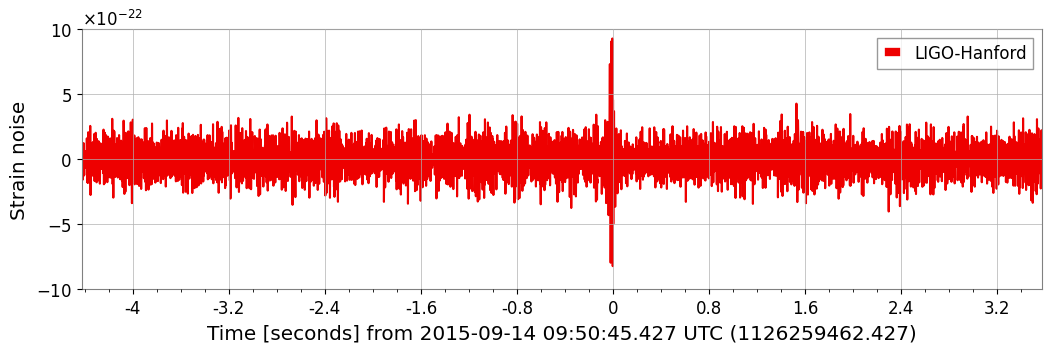

In [3]:
from gwpy.plot import Plot
%matplotlib inline

from astropy import units as u
import copy

h1b = copy.deepcopy(h1)
h1b = h1b.bandpass(50,250).notch(60).notch(120).crop(h1b.times[0]+1*u.s, h1b.times[-1]-0.9996*u.s)
#h1b = h1b.crop(h1b.times[0]+1*u.s, h1b.times[-1]-0.9996*u.s)

plot = Plot(figsize=(12, 4))
ax = plot.gca()
ax.set_xscale('auto-gps')
ax.plot(h1b, color='gwpy:ligo-hanford', label='LIGO-Hanford')
ax.set_epoch(1126259462.427)
ax.set_ylim(-1e-21, 1e-21)
ax.set_ylabel('Strain noise')
ax.legend()
plot.show()

# Prepare learning data

template length 1426 samples

half of the template contains the chirp

f_sampling 4096 Hz

In [4]:
print(h1b.data.shape)

print(h1b.sample_rate)


(32768,)
4096.0 Hz


# Install ML modules

In [5]:
!pip install pandas
!pip install scikit-learn

     |████████████████████████████████| 12.2 MB 3.1 MB/s eta 0:00:01
     |████████████████████████████████| 502 kB 98.2 MB/s eta 0:00:01
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
     |████████████████████████████████| 9.8 MB 2.0 MB/s eta 0:00:01
     |████████████████████████████████| 297 kB 67.4 MB/s eta 0:00:01
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [6]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model

In [7]:
#latent_dim = 128
latent_dim = 256

h1b_128 = np.reshape(h1b.data.tolist(), (-1, latent_dim)) / 10e-22
#h1b_128 = np.reshape(h1b.data.tolist(), (128, -1))

min_val = tf.reduce_min(h1b_128)
max_val = tf.reduce_max(h1b_128)

h1b_128 = (h1b_128 - min_val) / (max_val - min_val)

h1b_128 = tf.cast(h1b_128, tf.float32)

df = pd.DataFrame(h1b_128)

msk = np.random.rand(len(df)) < 0.8

train = df.loc[msk]

test = df.loc[~msk]

In [8]:
train

,0,1,2,3,4,5,6,7,8,9,...,246,247,248,249,250,251,252,253,254,255
0,0.455296,0.449434,0.443044,0.437544,0.434202,0.433950,0.437250,0.444038,0.453753,0.465438,...,0.486187,0.494633,0.500956,0.504548,0.504956,0.501914,0.495378,0.485534,0.472804,0.457825
2,0.378287,0.392453,0.411268,0.433291,0.456926,0.480568,0.502737,0.522179,0.537938,0.549395,...,0.384810,0.370068,0.361542,0.359601,0.364192,0.374839,0.390680,0.410513,0.432873,0.456122
3,0.478554,0.498508,0.514485,0.525259,0.529968,0.528199,0.520029,0.506039,0.487286,0.465230,...,0.436279,0.434429,0.434478,0.437488,0.444082,0.454317,0.467649,0.482982,0.498805,0.513393
4,0.525033,0.532274,0.534132,0.530254,0.521000,0.507440,0.491258,0.474573,0.459701,0.448882,...,0.486232,0.492449,0.502475,0.515621,0.530680,0.546043,0.559869,0.570299,0.575673,0.574754
5,0.566910,0.552229,0.531567,0.506485,0.479113,0.451922,0.427449,0.408010,0.395430,0.390835,...,0.489052,0.466326,0.446274,0.430664,0.420738,0.417093,0.419639,0.427629,0.439759,0.454332
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121,0.469011,0.466243,0.463313,0.460891,0.459534,0.459626,0.461356,0.464718,0.469549,0.475577,...,0.511359,0.492482,0.470913,0.447744,0.424182,0.401477,0.380858,0.363472,0.350335,0.342285
122,0.339948,0.343703,0.353650,0.369569,0.390897,0.416713,0.445747,0.476421,0.506929,0.535358,...,0.433739,0.434610,0.439939,0.448919,0.460330,0.472693,0.484442,0.494098,0.500423,0.502549
123,0.500067,0.493073,0.482160,0.468374,0.453116,0.438007,0.424725,0.414825,0.409562,0.409744,...,0.396807,0.414245,0.437875,0.465127,0.493024,0.518559,0.539053,0.552467,0.557626,0.554325
124,0.543309,0.526149,0.505015,0.482404,0.460844,0.442610,0.429505,0.422703,0.422676,0.429200,...,0.593820,0.596648,0.594808,0.587428,0.573917,0.554097,0.528317,0.497523,0.463265,0.427640


In [9]:
# 

In [10]:
class Autoencoder(Model):
    def __init__(self, latent_dim):
        super(Autoencoder, self).__init__()
        self.latent_dim = latent_dim   
        self.encoder = tf.keras.Sequential([
          #layers.Flatten(),
          layers.Dense(latent_dim/4, activation='relu'),
        ])
        self.decoder = tf.keras.Sequential([
          layers.Dense(latent_dim, activation='sigmoid'),
          #layers.Reshape((28, 28))
        ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

autoencoder = Autoencoder(latent_dim)

In [11]:
'''
class AnomalyDetector(Model):
    def __init__(self):
        super(AnomalyDetector, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = tf.keras.Sequential([
          layers.Dense(latent_dim, activation="relu"),
          layers.Dense(64, activation="relu"),
          layers.Dense(32, activation="relu")])

        self.decoder = tf.keras.Sequential([
          layers.Dense(32, activation="relu"),
          layers.Dense(64, activation="relu"),
          layers.Dense(latent_dim, activation="sigmoid")])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

autoencoder = AnomalyDetector()
'''

'\nclass AnomalyDetector(Model):\n    def __init__(self):\n        super(AnomalyDetector, self).__init__()\n        self.latent_dim = latent_dim\n        self.encoder = tf.keras.Sequential([\n          layers.Dense(latent_dim, activation="relu"),\n          layers.Dense(64, activation="relu"),\n          layers.Dense(32, activation="relu")])\n\n        self.decoder = tf.keras.Sequential([\n          layers.Dense(32, activation="relu"),\n          layers.Dense(64, activation="relu"),\n          layers.Dense(latent_dim, activation="sigmoid")])\n\n    def call(self, x):\n        encoded = self.encoder(x)\n        decoded = self.decoder(encoded)\n        return decoded\n\nautoencoder = AnomalyDetector()\n'

In [12]:
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

# Train the model

In [13]:
history = autoencoder.fit(train, train,
                epochs=200,
                shuffle=True,
                validation_data=(test, test))


Epoch 1/200
4/4 [==============================] - 0s 39ms/step - loss: 0.0082 - val_loss: 0.0078
Epoch 2/200
4/4 [==============================] - 0s 6ms/step - loss: 0.0050 - val_loss: 0.0069
Epoch 3/200
4/4 [==============================] - 0s 6ms/step - loss: 0.0044 - val_loss: 0.0066
Epoch 4/200
4/4 [==============================] - 0s 6ms/step - loss: 0.0042 - val_loss: 0.0065
Epoch 5/200
4/4 [==============================] - 0s 6ms/step - loss: 0.0042 - val_loss: 0.0064
Epoch 6/200
4/4 [==============================] - 0s 6ms/step - loss: 0.0041 - val_loss: 0.0064
Epoch 7/200
4/4 [==============================] - 0s 6ms/step - loss: 0.0039 - val_loss: 0.0063
Epoch 8/200
4/4 [==============================] - 0s 6ms/step - loss: 0.0039 - val_loss: 0.0062
Epoch 9/200
4/4 [==============================] - 0s 6ms/step - loss: 0.0038 - val_loss: 0.0062
Epoch 10/200
4/4 [==============================] - 0s 5ms/step - loss: 0.0037 - val_loss: 0.0061
Epoch 11/200
4/4 [==========

4/4 [==============================] - 0s 5ms/step - loss: 0.0016 - val_loss: 0.0033
Epoch 168/200
4/4 [==============================] - 0s 5ms/step - loss: 0.0016 - val_loss: 0.0033
Epoch 169/200
4/4 [==============================] - 0s 5ms/step - loss: 0.0016 - val_loss: 0.0033
Epoch 170/200
4/4 [==============================] - 0s 5ms/step - loss: 0.0016 - val_loss: 0.0033
Epoch 171/200
4/4 [==============================] - 0s 5ms/step - loss: 0.0016 - val_loss: 0.0033
Epoch 172/200
4/4 [==============================] - 0s 5ms/step - loss: 0.0016 - val_loss: 0.0033
Epoch 173/200
4/4 [==============================] - 0s 6ms/step - loss: 0.0016 - val_loss: 0.0032
Epoch 174/200
4/4 [==============================] - 0s 5ms/step - loss: 0.0016 - val_loss: 0.0032
Epoch 175/200
4/4 [==============================] - 0s 5ms/step - loss: 0.0015 - val_loss: 0.0033
Epoch 176/200
4/4 [==============================] - 0s 5ms/step - loss: 0.0015 - val_loss: 0.0033
Epoch 177/200
4/4 [=====

# See the statistics and the result of training

In [14]:
autoencoder.encoder.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                16448     
                                                                 
Total params: 16,448
Trainable params: 16,448
Non-trainable params: 0
_________________________________________________________________


In [15]:
autoencoder.decoder.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 256)               16640     
                                                                 
Total params: 16,640
Trainable params: 16,640
Non-trainable params: 0
_________________________________________________________________


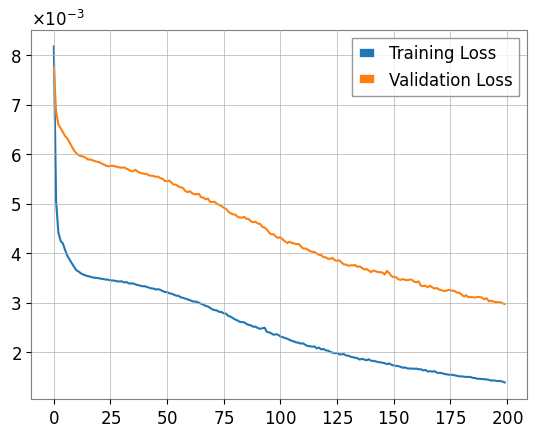

In [16]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()

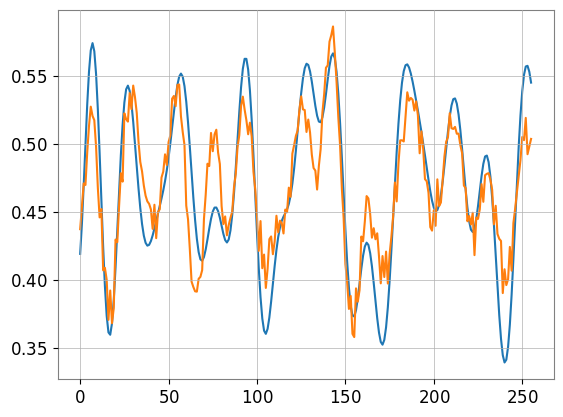

In [17]:
#sample = train.loc[50]
#sample = test.loc[3]

sample = df.loc[7]

plt.plot(sample)
plt.plot(autoencoder.call(np.expand_dims(sample, axis=1).T).numpy().T)

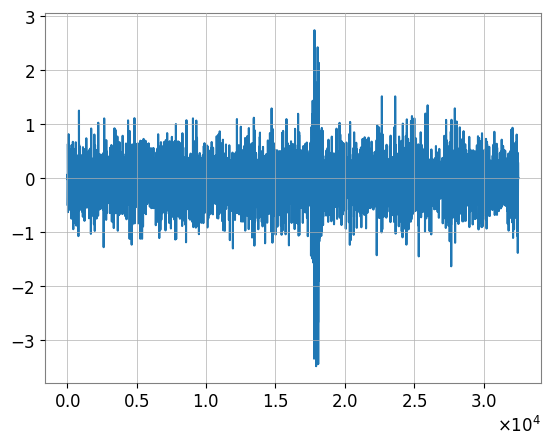

In [18]:
h1b_np = np.expand_dims(np.array(h1b.data.tolist()), axis=1).T / 10e-22

h1b_np = (h1b_np - min_val) / (max_val - min_val)

h1b_np = tf.cast(h1b_np, tf.float32)

steps = h1b_np.numpy().size - latent_dim

res = np.zeros(steps)

ran = int(steps/10)-1
#ran = 40

for i in range(ran):
    #print(i)
    inp = h1b_np[:,i*10:(i*10 + latent_dim)]
    a = autoencoder.call(inp).numpy()
    res[i*10] = np.sum(a[0] - inp[0])
    
    #plt.plot(inp[0])
    #plt.plot(a[0])
    #plt.show()

plt.plot(res)
#plt.plot(h1b_np[:steps])

3250


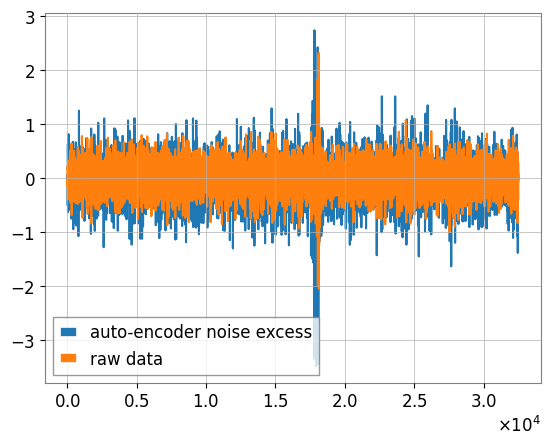

In [19]:
print(ran)
plt.plot(res, label='auto-encoder noise excess')
plt.plot(np.array(h1b.data.tolist())[:-latent_dim]/4e-22, label='raw data')
plt.legend()